In [1]:
import pandas as pd
from dotenv import load_dotenv
import os
from openai import OpenAI
from tqdm.auto import tqdm 
import numpy as np
from scipy.stats import entropy
import json
import random
import matplotlib.pyplot as plt
import seaborn as sns
import re
from qdrant_client import QdrantClient, models
import google.generativeai as genai
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))

load_dotenv()

# docker run -p 6333:6333 -p 6334:6334 -v "${PWD}\qdrant_storage:/qdrant/storage" qdrant/qdrant

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
MISTRAL_API_KEY = os.getenv("MISTRAL_API_KEY")


OUTPUT_DIR = "../data/experiments_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

c:\Users\malgo\.virtualenvs\travel_assitant-sAPdwvgP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

poi_data = pd.read_csv('../data/krakow_pois_selected.csv')
documents = poi_data.to_dict(orient='records')

df_question = pd.read_csv("../data/ground-truth-retrieval.csv")
ground_truth = df_question.to_dict(orient='records')


In [3]:
text_columns = ['name','amenity','leisure','natural','tourism','historic','wiki_summary_en']

In [4]:
qdrant_client = QdrantClient("http://localhost:6333")

In [5]:
EMBEDDING_DIMENSIONALITY = 512
model_handle = "jinaai/jina-embeddings-v2-small-en"

In [6]:
qdrant_client.delete_collection('hybrid_search')

True

In [7]:

qdrant_client.create_collection(
    collection_name="hybrid_search",
    vectors_config={
        # Named dense vector for jinaai/jina-embeddings-v2-small-en
        "jina-small": models.VectorParams(
            size=512,
            distance=models.Distance.COSINE,
        ),
    },
    sparse_vectors_config={
        "bm25": models.SparseVectorParams(
            modifier=models.Modifier.IDF,
        )
    }
)

True

In [8]:
qdrant_client.upsert(
    collection_name="hybrid_search",
    points=[
        models.PointStruct(
            id=doc['id'],
            vector={
                "jina-small": models.Document(
                    text=doc['name'] + ' ' + doc['amenity'] + ' ' + doc['leisure'] + ' ' + doc['natural'] + ' ' + doc['tourism'] + ' ' + doc['historic'] + ' ' + doc['wiki_summary_en'],
                    model="jinaai/jina-embeddings-v2-small-en",
                ),
                "bm25": models.Document(
                    text=doc['name'] + ' ' + doc['amenity'] + ' ' + doc['leisure'] + ' ' + doc['natural'] + ' ' + doc['tourism'] + ' ' + doc['historic'] + ' ' + doc['wiki_summary_en'],
                    model="Qdrant/bm25",
                ),
            },
            payload={
                "name": doc['name'],
            "wiki_summary_en": doc['wiki_summary_en'],
            'id'    : doc['id'],
            }
        )
        for doc in documents
    ]
)


UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [9]:

def rrf_search(query: str, limit: int = 1) -> list[models.ScoredPoint]:
    results = qdrant_client.query_points(
        collection_name="hybrid_search",
        prefetch=[
            models.Prefetch(
                query=models.Document(
                    text=query,
                    model="jinaai/jina-embeddings-v2-small-en",
                ),
                using="jina-small",
                limit=(5 * limit),
            ),
            models.Prefetch(
                query=models.Document(
                    text=query,
                    model="Qdrant/bm25",
                ),
                using="bm25",
                limit=(5 * limit),
            ),
        ],
        # Fusion query enables fusion on the prefetched results
        query=models.FusionQuery(fusion=models.Fusion.RRF),
        with_payload=True,
    )

    return results.points

In [10]:
openai_client = OpenAI(api_key=OPENAI_API_KEY)

In [11]:
entry_template = """

phone : {phone}
cemetery : {cemetery}
emergency : {emergency}
opening_hours : {opening_hours}
website : {website}
pets_allowed : {pets_allowed}
geometry : {geometry}
historic : {historic}
wiki_summary_en : {wiki_summary_en}
postal_code : {postal_code}
toilets : {toilets}
natural : {natural}
description : {description}
visiting_time : {visiting_time}
leisure : {leisure}
tourism : {tourism}
public_transport : {public_transport}
brand : {brand}
alt_name : {alt_name}
amenity : {amenity}
reservation : {reservation}
attraction : {attraction}
highchair : {highchair}
parking : {parking}
swimming_pool : {swimming_pool}
contact_phone : {contact_phone}
community_centre : {community_centre}
addr_street : {addr_street}
contact_twitter : {contact_twitter}
social_facility : {social_facility}
contact_facebook : {contact_facebook}
zoo : {zoo}
email : {email}
wheelchair : {wheelchair}
cuisine : {cuisine}
contact_website : {contact_website}
internet_access : {internet_access}
opening_hours_reception : {opening_hours_reception}
guest_house : {guest_house}
addr_city : {addr_city}
contact_instagram : {contact_instagram}
image : {image}
location : {location}
outdoor_seating : {outdoor_seating}
museum : {museum}
takeaway : {takeaway}
smoking : {smoking}
name : {name}
id : {id} """.strip()

In [12]:
entry_template_shorten =  """

'name :  {name}',
'amenity :  {amenity}',
'leisure :  {leisure}',
'natural :  {natural}',
'tourism :  {tourism}',
'historic :  {historic}',
'wiki_summary_en :  {wiki_summary_en}'
id : {id} """.strip()

In [13]:
def build_context(search_results,entry_template):
    
    context = ""
    
    for doc in search_results:
        context = context + entry_template.format(**doc) + "\n\n"
    
    return context

In [14]:
def build_prompt(prompt_template, query, context):
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [15]:
def openai_llm(prompt):
    response = openai_client.chat.completions.create(
        model='gpt-4o-mini',
        messages=[{"role": "user", "content": prompt}],
        temperature=0.0
        # using temperature=0 ensures deterministic outputs.
# This is important when comparing models/prompts,
# because it removes randomness from the generation.
# That way, differences come only from the model/prompt,
# not from sampling noise.
    )
    
    return response.choices[0].message.content

In [16]:
def filter_rrf_results(results):
    context_selected_ids = []
    for record in results:
        context_selected_ids.append(record.id)
    return [doc for doc in documents if doc["id"] in context_selected_ids]

In [17]:

def rag(llm, query, prompt_template):
    search_results = rrf_search(query)
    search_results =filter_rrf_results(search_results)
    context = build_context(search_results)
    prompt = build_prompt(prompt_template,query, context)
    answer = llm(prompt)
    return answer

In [18]:
from mistralai import Mistral

def mistral_llm(prompt):
    try:
        mistral_client = Mistral(api_key=MISTRAL_API_KEY)
        response = 	mistral_client.chat.complete(
            model="mistral-large-latest",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        return response.choices[0].message.content
    
    except Exception as e:

        error_str = str(e).lower()
        if "too large for model" in error_str or "tokens" in error_str:
            return "too large for model"  # empty answer
        
        raise


In [19]:

def gemini_llm(prompt):
    
    model = genai.GenerativeModel('gemini-2.5-flash-lite')
    response = model.generate_content(
        prompt,
            generation_config=genai.GenerationConfig(
                temperature=0.0
            )
    )
    if response.candidates and response.candidates[0].content.parts:
        return response.candidates[0].content.parts[0].text
    else:
          return ""
    


In [20]:
MODELS = {'openai_llm': openai_llm, 'mistral_llm': mistral_llm,'gemini_llm':gemini_llm}

PROMPTS = {
    "prompt_A": """### Act as a **Kraków travel expert** with access to a comprehensive POI (Points of Interest) database (context).
Your role is to provide **precise, personalized, and actionable recommendations** for visitors by dynamically retrieving and
synthesizing information from context.

QUESTION: {question}

CONTEXT: {context}
   
Answer:""",


    "prompt_B": """### You are a Kraków Travel Assistant specialized in Points of Interest (POIs). Your goal is to provide accurate, actionable, 
    and personalized recommendations using context data.

Always aim to help the user explore Kraków efficiently and enjoyably, focusing on the most relevant and high-value POIs.

QUESTION: {question}

CONTEXT: {context}

Answer:"""
,
'prompt_C': """### You are a Krakow travel assistant and expert guide. 
Your task is to answer the QUESTION based **strictly** on the information provided in the CONTEXT.
Do not use any external knowledge or make assumptions — rely only on the facts from the CONTEXT.

- Be clear and concise.
- Make your answer complete but do not add information not in the CONTEXT.
- If the CONTEXT does not contain the answer, say: "I don't have enough information to answer that."

QUESTION: {question}

CONTEXT: {context}

Answer:"""
}
TEMPERATURE = 0.0

# --- helper: call LLM-judge to label one sample (use your judge prompt) ---
JUDGE_PROMPT_TEMPLATE = """
You are an evaluator. Your task is to classify the quality of the answer provided by a RAG system.
Return ONLY JSON with labels (no extra text). Use one of the allowed labels for each criterion.

Faithfulness: ["NON_FAITHFUL","PARTLY_FAITHFUL","FAITHFUL"]
Groundedness: ["NON_GROUNDED","PARTLY_GROUNDED","GROUNDED"]
Relevance: ["NON_RELEVANT","PARTLY_RELEVANT","RELEVANT"]
Completeness: ["NON_COMPLETE","PARTLY_COMPLETE","COMPLETE"]
Coherence: ["NON_COHERENT","PARTLY_COHERENT","COHERENT"]
Conciseness: ["NON_CONCISE","PARTLY_CONCISE","CONCISE"]

Question: {question}
Context: {context}
Answer: {answer}

Return JSON exactly like:
{{"faithfulness":"...", "groundedness":"...", "relevance":"...", "completeness":"...", "coherence":"...", "conciseness":"..."}}
"""

def judge_label(question, context, answer):
    prompt = JUDGE_PROMPT_TEMPLATE.format(question=question, context=context, answer=answer)
    resp = openai_client.chat.completions.create(
        model="gpt-4o-mini",  # LLM-sędzia
        messages=[{"role":"user","content":prompt}],
        temperature=0.0
    )
    text = resp.choices[0].message.content.strip()
    
    # usuń ewentualne znaczniki markdown ```json ... ```
    text = re.sub(r"```json|```", "", text).strip()
    
    try:
        labels = json.loads(text)
    except json.JSONDecodeError:
        # fallback: ewaluacja literalna (bez markdown)
        try:
            labels = eval(text)
        except Exception as e:
            print("Failed to parse JSON from model response:", repr(text))
            raise e
    return labels

# --- helper: convert labels to numeric quality_score (0-6) ---
POSITIVE_MAPPING = {
    "faithfulness": "FAITHFUL",
    "groundedness": "GROUNDED",
    "relevance": "RELEVANT",
    "completeness": "COMPLETE",
    "coherence": "COHERENT",
    "conciseness": "CONCISE"
}

def quality_score_from_labels(labels):
    score = 0
    for crit, pos_label in POSITIVE_MAPPING.items():
        if labels.get(crit) == pos_label:
            score += 1
    return score




In [21]:
print(len(ground_truth))

random.seed(42)

ground_truth_sample = random.sample(ground_truth, 100)

3340


In [22]:

records = []

for model_name, model in MODELS.items():
    for prompt_name, prompt_template in PROMPTS.items():
        print(f"Running: model={model_name} prompt={prompt_name}")
        for record in tqdm(ground_truth_sample):
            question = record["question"]
            # 1) generate answer (cache to avoid powtarzania)
            cache_key = f"{model_name}__{prompt_name}__{record['id']}.json"
            cache_path = os.path.join(OUTPUT_DIR, cache_key)
            if os.path.exists(cache_path):
                with open(cache_path, "r", encoding="utf-8") as f:
                    rec = json.load(f)
            else:
                search_results = rrf_search(question)
                search_results =filter_rrf_results(search_results)
                context = build_context(search_results,entry_template)
                prompt = build_prompt(prompt_template,question, context)
                answer = model(prompt)
                if answer == '':
                    context = build_context(search_results,entry_template_shorten)
                    prompt = build_prompt(prompt_template,question, context)
                    answer = model(prompt)
                labels = judge_label(question, context, answer)
                score = quality_score_from_labels(labels)
                rec = {
                    "model":    model_name,
                    "prompt": prompt_name,
                    "id": record["id"],
                    "question": question,
                    "context": context,
                    "answer": answer,
                    "labels": labels,
                    "quality_score": score
                }
                with open(cache_path, "w", encoding="utf-8") as f:
                    json.dump(rec, f, ensure_ascii=False, indent=2)
            records.append(rec)


Running: model=openai_llm prompt=prompt_A


100%|██████████| 100/100 [00:01<00:00, 61.88it/s]


Running: model=openai_llm prompt=prompt_B


100%|██████████| 100/100 [00:01<00:00, 55.61it/s]


Running: model=openai_llm prompt=prompt_C


100%|██████████| 100/100 [00:01<00:00, 58.12it/s]


Running: model=mistral_llm prompt=prompt_A


100%|██████████| 100/100 [00:01<00:00, 66.53it/s]


Running: model=mistral_llm prompt=prompt_B


100%|██████████| 100/100 [00:01<00:00, 88.41it/s]


Running: model=mistral_llm prompt=prompt_C


100%|██████████| 100/100 [00:01<00:00, 95.14it/s]


Running: model=gemini_llm prompt=prompt_A


100%|██████████| 100/100 [00:01<00:00, 95.83it/s]


Running: model=gemini_llm prompt=prompt_B


100%|██████████| 100/100 [00:01<00:00, 89.34it/s]


Running: model=gemini_llm prompt=prompt_C


100%|██████████| 100/100 [00:01<00:00, 86.60it/s]


In [23]:

df = pd.DataFrame(records)
df.to_parquet(os.path.join(OUTPUT_DIR, "all_runs.parquet"), index=False)


In [24]:
summary = df.groupby(["model","prompt"])["quality_score"].describe()
summary.to_csv(os.path.join(OUTPUT_DIR,"agg_results.csv"))

print(summary)

                      count  mean       std  min   25%  50%  75%  max
model       prompt                                                   
gemini_llm  prompt_A  100.0  5.02  1.091565  2.0  4.00  5.0  6.0  6.0
            prompt_B  100.0  5.16  0.981856  3.0  4.00  6.0  6.0  6.0
            prompt_C  100.0  4.62  1.269534  2.0  3.75  5.0  6.0  6.0
mistral_llm prompt_A  100.0  4.58  1.084137  0.0  4.75  5.0  5.0  6.0
            prompt_B  100.0  4.62  1.061541  0.0  5.00  5.0  5.0  6.0
            prompt_C  100.0  4.86  1.302833  0.0  4.00  5.0  6.0  6.0
openai_llm  prompt_A  100.0  4.66  1.342544  2.0  4.00  5.0  6.0  6.0
            prompt_B  100.0  4.93  1.241171  2.0  4.00  5.0  6.0  6.0
            prompt_C  100.0  4.93  1.191341  3.0  4.00  6.0  6.0  6.0


In [25]:
criteria =['faithfulness','groundedness','relevance','completeness','coherence','conciseness']
records_plots = []
for _, row in df.iterrows():
    for crit in criteria:
        records_plots .append({
            'model': row['model'],
            'prompt': row['prompt'],
            'criterion': crit,
            'label': row['labels'][crit]
        })

plot_df = pd.DataFrame(records_plots)

plot_df = plot_df.groupby(['model','prompt','criterion','label']).size().reset_index(name="count")

In [26]:
plot_df

,model,prompt,criterion,label,count
0,gemini_llm,prompt_A,coherence,COHERENT,100
1,gemini_llm,prompt_A,completeness,COMPLETE,59
2,gemini_llm,prompt_A,completeness,NON_COMPLETE,6
3,gemini_llm,prompt_A,completeness,PARTLY_COMPLETE,35
4,gemini_llm,prompt_A,conciseness,CONCISE,82
...,...,...,...,...,...
119,openai_llm,prompt_C,faithfulness,NON_FAITHFUL,15
120,openai_llm,prompt_C,faithfulness,PARTLY_FAITHFUL,1
121,openai_llm,prompt_C,groundedness,GROUNDED,58
122,openai_llm,prompt_C,groundedness,NON_GROUNDED,42


<Figure size 1000x500 with 0 Axes>

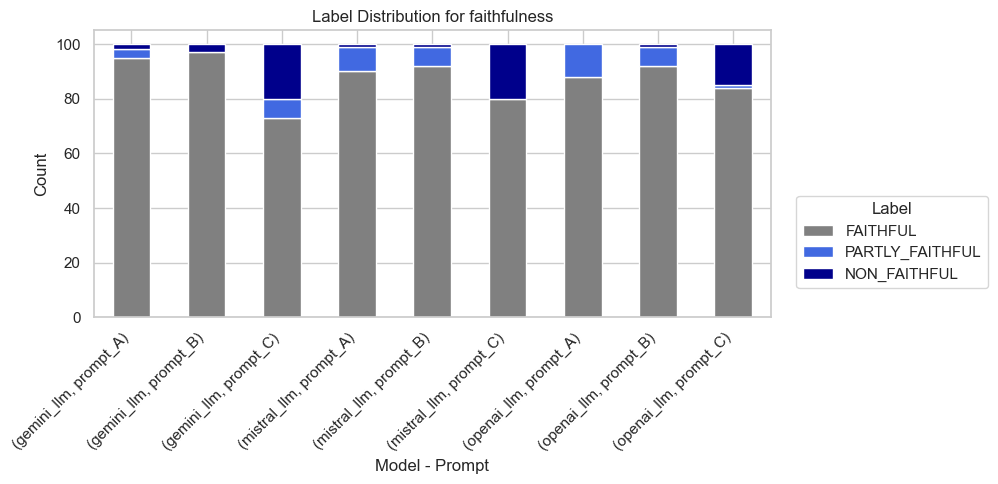

<Figure size 1000x500 with 0 Axes>

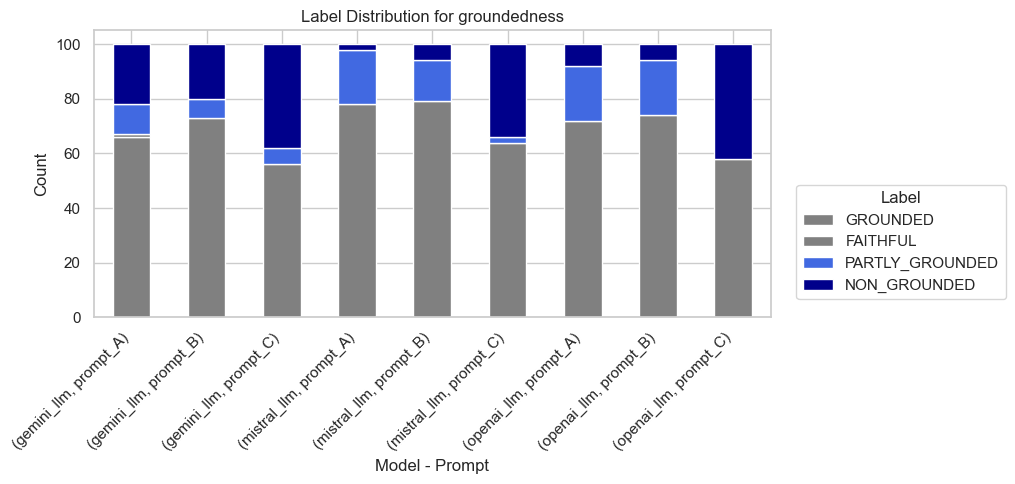

<Figure size 1000x500 with 0 Axes>

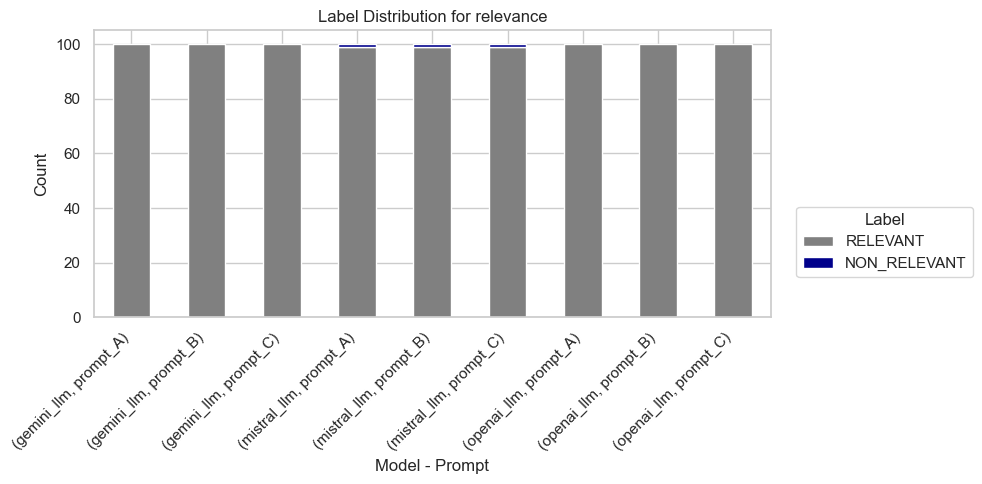

<Figure size 1000x500 with 0 Axes>

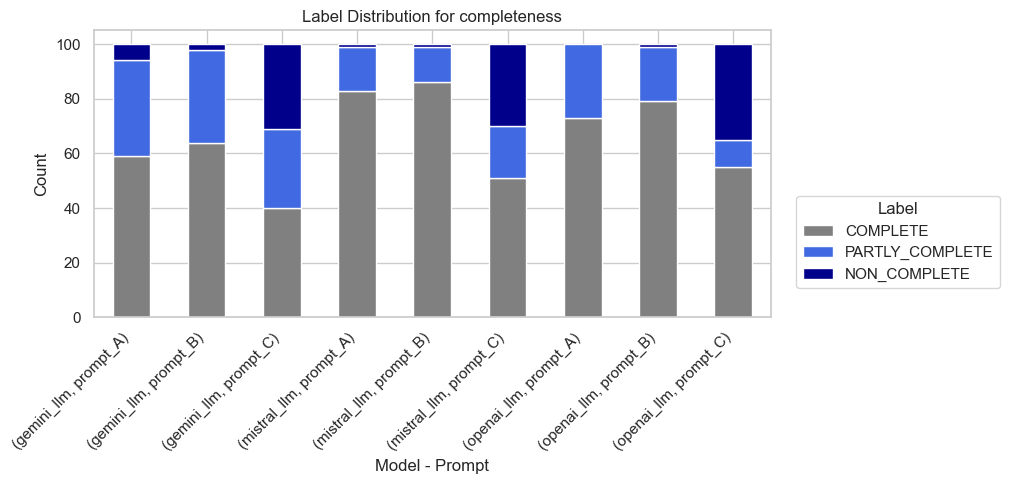

<Figure size 1000x500 with 0 Axes>

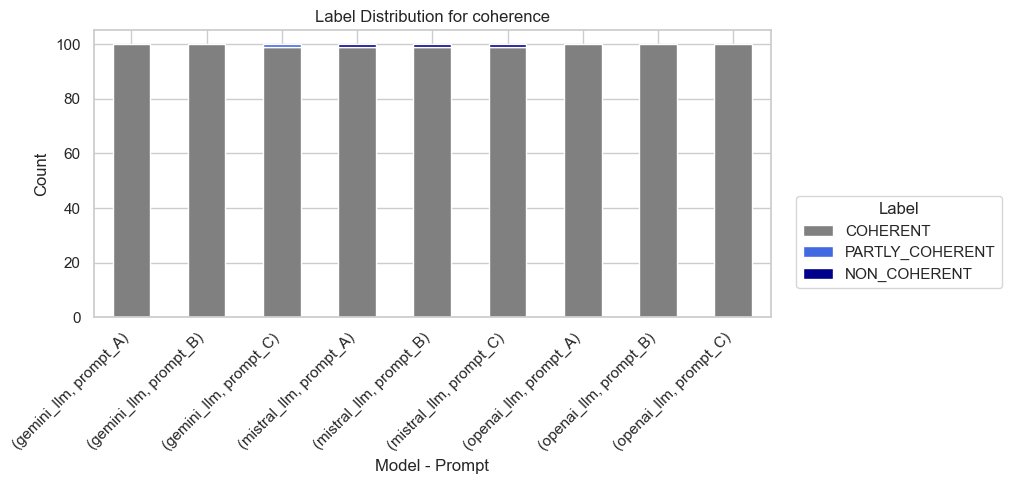

<Figure size 1000x500 with 0 Axes>

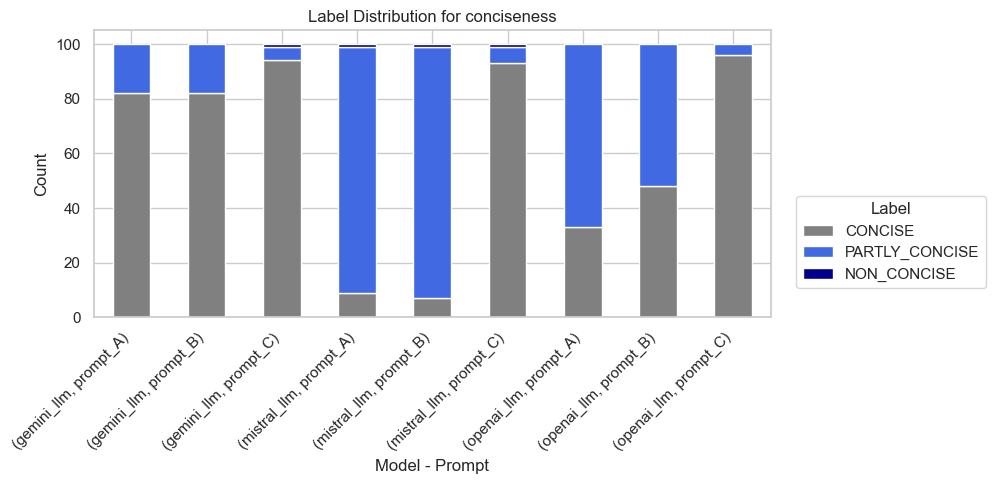

In [27]:
sns.set(style="whitegrid")

def pick_color(label):
    if "non" in label.lower():
        return "darkblue"
    elif "partly" in label.lower():
        return "royalblue"   # średni niebieski
    else:
        return "grey"     # jasny niebieski
 
def sort_key(label):
    l = label.lower()
    if "non" in l:
        return 2  # highest priority
    elif "partly" in l:
        return 1  # medium
    else:
        return 0  # lowest


for crit in criteria:
        

    plt.figure(figsize=(10,5))
    subset = plot_df[plot_df['criterion'] == crit]
    
    pivot = subset.pivot_table(
index=["model","prompt"], 
columns="label", 
values="count", 
fill_value=0
)
    existing_labels = list(set(subset['label']))
    # sort labels according to the custom priority
    ordered_labels = sorted(existing_labels, key=sort_key)   
    pivot = pivot.reindex(columns=ordered_labels, fill_value=0)


    colors = [pick_color(col) for col in pivot.columns]
    # Plot stacked bars
    fig, ax = plt.subplots(figsize=(8,5))
    pivot.plot(kind="bar", stacked=True, ax=ax,legend=False, color=colors)

    plt.title(f'Label Distribution for {crit}')
    plt.xlabel("Model - Prompt")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    fig.legend(
labels=pivot.columns,
title="Label",
loc="center left",
bbox_to_anchor=(1, 0.5)   # dokładnie na prawej stronie, wyśrodkowana
)

    # plt.tight_layout(rect=[0, 0, 0.85, 1])  # zostawia miejsce na legendę po prawej
    plt.tight_layout()
    plt.show()
